# Deriving cancer gene's from expression data

See if it's possible to train a deep neural network tumor/normal binary classifier using just the Toil TCGA, TARGET and GTEX expression datasets:

https://xenabrowser.net/datapages/?host=https://toil.xenahubs.net)

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

# fix random seed for reproducibility
np.random.seed(42)

In [3]:
"""
Detect if there are GPU's on this box and if so use them politely. If not use the CPU.
"""
import re
import subprocess
import keras.backend.tensorflow_backend

def get_session():
    return tf.Session(config=tf.ConfigProto(log_device_placement=True, allow_soft_placement=True,
                                            gpu_options=tf.GPUOptions(allow_growth=True)))
keras.backend.tensorflow_backend.set_session(get_session())

In [4]:
from keras.utils.io_utils import HDF5Matrix
import h5py

input_file = "data/tumor_normal.h5"

with h5py.File(input_file, "r") as f:
    print("Datasets:", list(f.keys()))

X_train = HDF5Matrix(input_file, "X_train")
X_test = HDF5Matrix(input_file, "X_test")
y_train = HDF5Matrix(input_file, "y_train")
y_test = HDF5Matrix(input_file, "y_test")

print("Training on full dataset")

num_epochs = 8
batch_size = 128
    
print("X_train.shape:", X_train.shape, "epochs:", num_epochs, "batch_size:", batch_size)

Datasets: ['X_test', 'X_train', 'class_labels', 'classes_test', 'classes_train', 'features', 'genes', 'labels', 'y_test', 'y_train']
Training on full dataset
X_train.shape: (15300, 60498) epochs: 8 batch_size: 128


In [85]:
"""
Batch normalization with a sparse layer.

Achieves on Test:
3744/3826 [============================>.] - ETA: 0s(['loss', 'acc'], [0.52888519396363787, 0.89388395178336721])
"""
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

classify = [
    InputLayer(input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    
    # apparently a linear classifier does quite well
    
#     Dense(100),
#     BatchNormalization(),
#     Activation('relu'),
#     Dropout(0.5),

#     Dense(1000, activity_regularizer=regularizers.l1(1e-5)),
#     BatchNormalization(),
#     Activation('relu'),
#     Dropout(0.5),
    
#     Dense(500),
#     Activation('relu'),
#     Dropout(0.5),
    
#     Dense(500),
#     Activation('relu'),
#     Dropout(0.5),
    
    Dense(1),
    Activation('sigmoid')
]

model = Sequential(classify)

from keras import optimizers
# SGD with a too-high learning rate somehow prevents overfitting and allows for super-.93 accuracy
optim = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])

# callbacks=[EarlyStopping(monitor='acc', min_delta=0.001, patience=2, verbose=2, mode="max")]
callbacks = []

history = model.fit(X_train, y_train, validation_split=0.1, epochs=8, batch_size=batch_size, shuffle="batch", callbacks=callbacks)

print(model.metrics_names, model.evaluate(X_test, y_test))

Train on 13770 samples, validate on 1530 samples
Epoch 1/8
13770/13770 [==============================] - 4s 322us/step - loss: 0.8444 - acc: 0.9375 - val_loss: 2.2452 - val_acc: 0.8229
Epoch 2/8
13770/13770 [==============================] - 2s 152us/step - loss: 0.6239 - acc: 0.9603 - val_loss: 0.8363 - val_acc: 0.9314
Epoch 3/8
13770/13770 [==============================] - 2s 148us/step - loss: 0.6277 - acc: 0.9603 - val_loss: 0.5599 - val_acc: 0.9641
Epoch 4/8
13770/13770 [==============================] - 2s 144us/step - loss: 0.6239 - acc: 0.9600 - val_loss: 0.5660 - val_acc: 0.9608
Epoch 5/8
13770/13770 [==============================] - 2s 144us/step - loss: 0.6132 - acc: 0.9611 - val_loss: 0.5301 - val_acc: 0.9654
Epoch 6/8
13770/13770 [==============================] - 2s 144us/step - loss: 0.6103 - acc: 0.9615 - val_loss: 0.5492 - val_acc: 0.9627
Epoch 7/8
13770/13770 [==============================] - 2s 143us/step - loss: 0.6068 - acc: 0.9617 - val_loss: 0.5377 - val_acc:

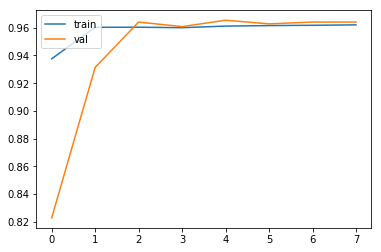

In [86]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [52]:
X_np = X_train.data.value

In [55]:
print('X_train mean, std: ', X_np.mean(), X_np.std())
# the input data is not normalized!

# so its clear the reason batchnorm is necessary is not that it learns very useful gamma/beta, but just for
# the normalization of input data
gamma, beta = classify[1].get_weights()[:2]
print('beta mean, std, max, min: ', beta.mean(), beta.std(), gamma.max(), gamma.min())
print('gamma mean, std, max, min: ', gamma.mean(), gamma.std(), gamma.max(), gamma.min())
# why are the min and max of beta/gamma the same? strange

X_train mean, std:  -5.10433 5.88025
beta mean, std, max, min:  -0.000611181 0.00772694 1.14909 0.882911
gamma mean, std, max, min:  0.992192 0.0221256 1.14909 0.882911


In [5]:
"""
Save model and weights so we can copy them back from the GPU machine
to visualize and evaluate locally.
"""
model_json = model.to_json()
if not os.path.exists("models"):
    os.makedirs("models")
with open("models/model.json", "w") as f:
    f.write(model.to_json())

model.save_weights("models/weights.h5")
print("Saved to model.json and weights.json")

Saved to model.json and weights.json
